# Sesión 9: Text Embedding

---

Jueves 12 de Octubre de 2023

In [1]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

Importamos IMDb dataset

In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

84125825/84125825 [==============================] - 22s 0us/step


['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [3]:
# Eliminamos las carpetas que no nos interesan

train_dir = os.path.join(dataset_dir, 'train')
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

### Creación del Dataset

In [4]:
batch_size = 1024
seed = 123

# Dividimos el dataset en train y test
train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='training', seed=seed)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [5]:
# Visualizamos los datos
for text_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print(label_batch[i].numpy(), text_batch.numpy()[i])

0 b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe"
1 b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully placed cynicism. If you like monty python, You will love this film. This movie is a tad bit "grease"esk (without

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

# Configuramos el dataset para que sea más rápido
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Capa de Text Embedding

In [9]:
embedding_layer = tf.keras.layers.Embedding(1000, 5) # 1000 palabras, 5 dimensiones
result = embedding_layer(tf.constant([1,2,3]))
print(result.numpy())

[[ 0.04632362 -0.03722023  0.0329275   0.00215411 -0.01136173]
 [-0.02677887  0.03697133  0.00431949 -0.02352194 -0.02317988]
 [ 0.04221928 -0.00587348  0.02784917 -0.023832    0.01093292]]


In [10]:
print(result.shape)
# (3, 5)
# 3 palabras, 5 dimensiones

(3, 5)


### Preprocesamiento de Texto

In [11]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data) # Estandariazmos el texto a minúsculas
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '') # Eliminamos los signos de puntuación

vocab_size = 10000
sequence_length = 100

# Creamos el vectorizador de texto
vectorize_layer = TextVectorization(
  standardize=custom_standardization,
  max_tokens=vocab_size,
  output_mode='int',
  output_sequence_length=sequence_length)

# Adaptamos el vectorizador al dataset de entrenamiento
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

### Modelo de Clasificación

In [12]:
embedding_dim = 16

# Creamos el modelo
model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),  # Asigna pesos a las palabras
  GlobalAveragePooling1D(), # Flattenig: Reduce la dimensionalidad
  Dense(16, activation='relu'),
  Dense(1)
])

In [14]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25)

Epoch 1/25
20/20 [==============================] - 1s 40ms/step - loss: 0.3471 - accuracy: 0.8503 - val_loss: 0.4052 - val_accuracy: 0.7970
Epoch 2/25
20/20 [==============================] - 1s 34ms/step - loss: 0.3329 - accuracy: 0.8576 - val_loss: 0.3993 - val_accuracy: 0.7996
Epoch 3/25
20/20 [==============================] - 1s 35ms/step - loss: 0.3207 - accuracy: 0.8626 - val_loss: 0.3937 - val_accuracy: 0.8044
Epoch 4/25
20/20 [==============================] - 1s 33ms/step - loss: 0.3093 - accuracy: 0.8676 - val_loss: 0.3892 - val_accuracy: 0.8076
Epoch 5/25
20/20 [==============================] - 1s 34ms/step - loss: 0.2988 - accuracy: 0.8733 - val_loss: 0.3858 - val_accuracy: 0.8102
Epoch 6/25
20/20 [==============================] - 1s 33ms/step - loss: 0.2890 - accuracy: 0.8770 - val_loss: 0.3832 - val_accuracy: 0.8114
Epoch 7/25
20/20 [==============================] - 1s 33ms/step - loss: 0.2799 - accuracy: 0.8821 - val_loss: 0.3812 - val_accuracy: 0.8162
Epoch 8/25
20

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160289 (626.13 KB)
Trainable params: 16028

### Descarga de datos

In [ ]:
weights = model.get_layer('embedding').get_weights()[0] # Obtenemos los pesos de la capa de embedding
vocab = vectorize_layer.get_vocabulary() # Obtenemos el vocabulario

# Guardamos los pesos y el vocabulario
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if  index == 0: continue # Omitimos el primer elemento
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")

out_v.close()
out_m.close()

Ingresamos los datos obtenidos en: https://projector.tensorflow.org/

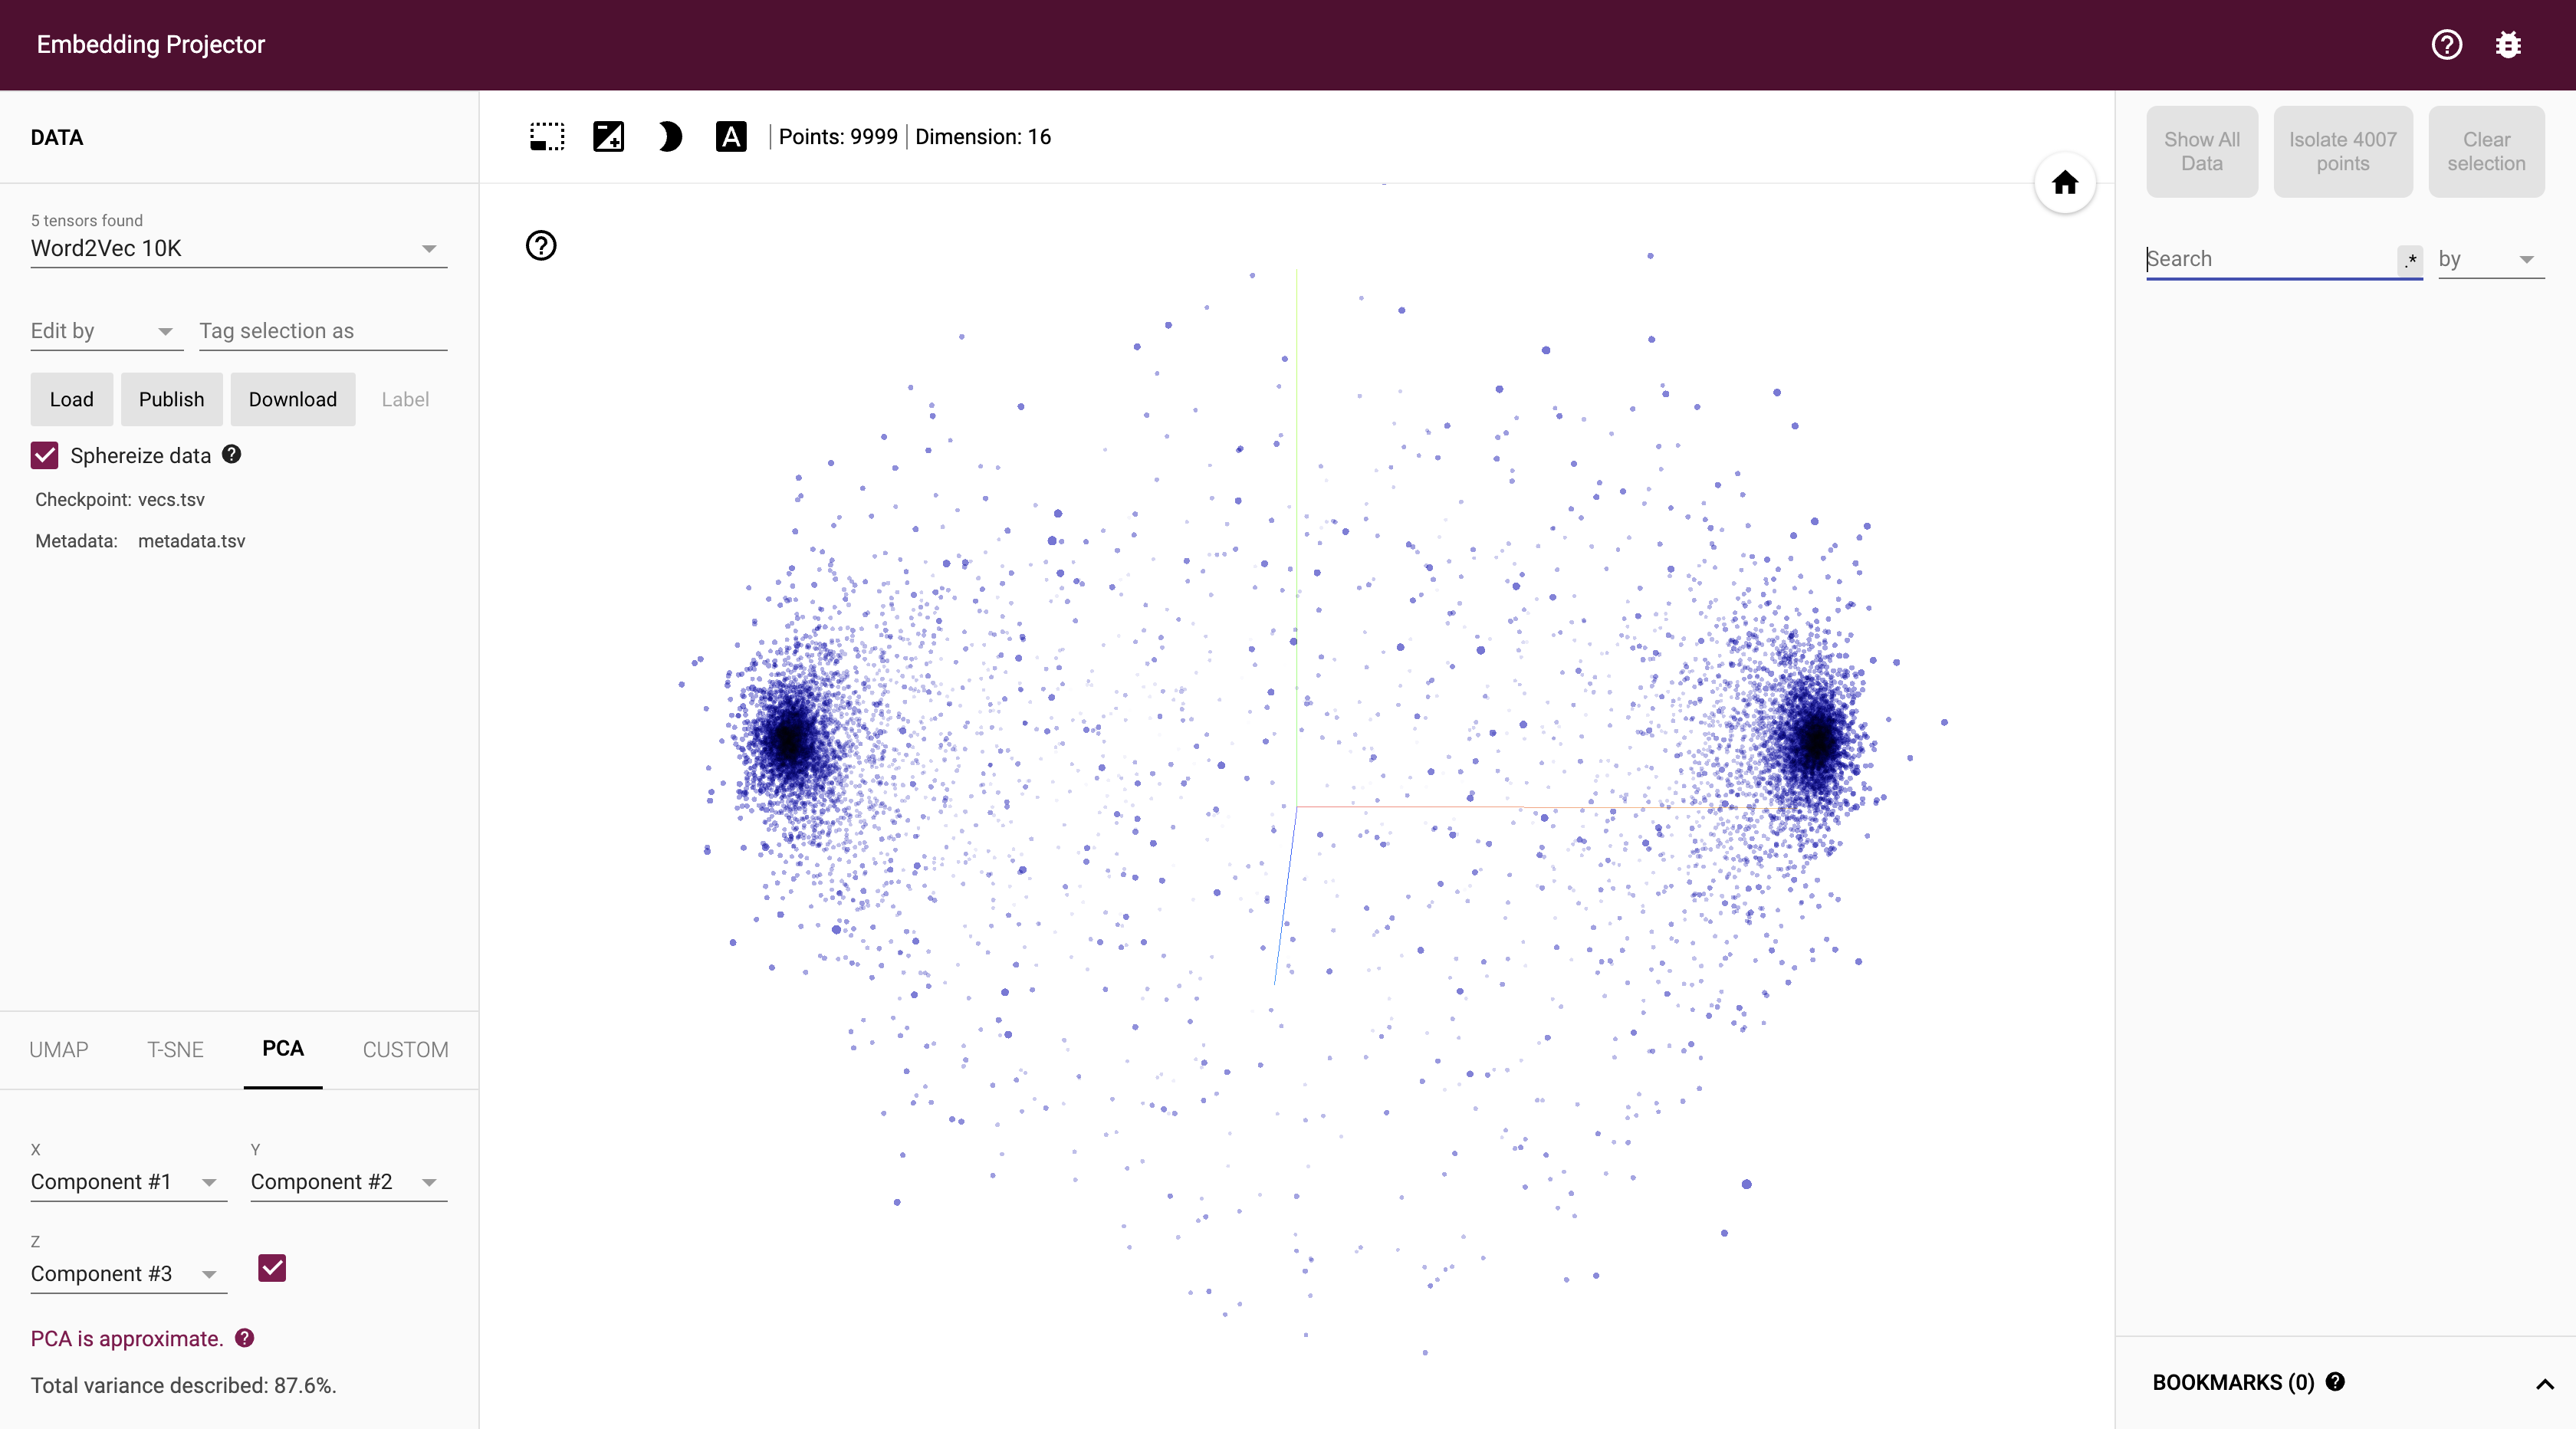